In [1]:
# Implementation of non-convex TREX with various max approximation (lq norm, log(exp),...)
# Using https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/ as template

In [37]:
path_figure = '/Users/cmueller/Documents/GitHub/Figures/'
import torch.nn as nn
import torch
from torch.autograd.variable import Variable
from torchvision import datasets,models,transforms

import matplotlib.pyplot as plt

# TREX example data

In [38]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

## Building linear regression in pytorch 

In [39]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [40]:
## Create a custom regression loss

class Regress_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Regress_Loss,self).__init__()
        
    def forward(self,x,y):
        y_shape = y.size()[1]
        x_added_dim = x.unsqueeze(1)
        x_stacked_along_dimension1 = x_added_dim.repeat(1,2,1)
        diff = torch.sum((y - x_stacked_along_dimension1)**2,2)
        totloss = torch.sum(torch.sum(torch.sum(diff)))
        return totloss
    

## Instantiate model

In [41]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [42]:
criterion = Regress_Loss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [43]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

RuntimeError: The size of tensor a (11) must match the size of tensor b (2) at non-singleton dimension 1

[[ 0.7825495 ]
 [ 0.41859746]
 [ 0.05464542]
 [-0.30930662]
 [-0.67325866]
 [-1.0372107 ]
 [-1.4011627 ]
 [-1.7651147 ]
 [-2.129067  ]
 [-2.493019  ]
 [-2.8569708 ]]


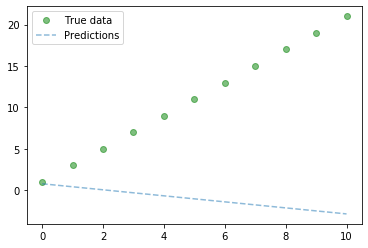

In [44]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()